# Abstract:

This Jupyter notebook contains a series of Python scripts designed to interact with Uniswap, retrieve price data for token pairs, and store this data in a database. The code comprises several key functions:

- **Insert New Pair into DB**: This function takes Uniswap pair contracts as input and ensures they are stored in the database. It retrieves contract ABIs, fetches the contracts, and records essential token information.
- **Insert Price for All Pairs**: The script processes all pairs in the database, retrieves their current prices, and saves this data into the database.
- **Get Last Price for All Pairs:** This function retrieves the most recent price data for all pairs stored in the database.
- **Get All Price Data for One Pair:** It allows the retrieval of the latest price information for a specific pair already present in the database.
- **Get Prices from All Pairs in the Database:** This script retrieves price data for all pairs stored in the database.
- **Plot Price Variations:** Lastly, the code includes functionality to visualize price variations for all pairs in the form of graphs, aiding in the analysis of price trends.

In [1]:
import requests
import json
from web3 import Web3
import mysql.connector
import time
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go




In [2]:

def fetch_contract_abi(contract_address, etherscan_api_key):
    """
    Fetch the ABI for a given Ethereum contract from Etherscan.
    
    Parameters:
        contract_address (str): The Ethereum address of the contract.
        etherscan_api_key (str): The API key for Etherscan.
        
    Returns:
        list: A Python list containing the ABI, or None if the request fails.
    """
    
    # Construct the API URL to fetch the ABI
    url = f"https://api.etherscan.io/api?module=contract&action=getabi&address={contract_address}&apikey={etherscan_api_key}"
    
    # Make the request
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if data['status'] == '1':
            abi = json.loads(data['result'])
            return abi
        else:
            print(f"Error fetching ABI: {data['message']}")
            return None
    else:
        print("Error fetching data from Etherscan")
        return None


def get_exchange_contract(contract_address, abi):
    """
    Get a Web3 contract object for uniswap V2.
    
    Parameters:
        contract_address (str): The Ethereum address of the contract.
        abi : The ABI of the contract.
        
    Returns:
        web3.Contract: A Web3 contract object.
    """
    
    infura_url = 'https://mainnet.infura.io/v3/eea4386c7304459fb33b2ccc5c7d446b'

    web3 = Web3(Web3.HTTPProvider(infura_url))
    address = Web3.to_checksum_address(contract_address)
    exchange_contract = web3.eth.contract(address=address, abi=abi)
    
    return exchange_contract


def get_token_info(infura_url, token_address):
    """
    Fetch token information such as name, symbol, and decimals.
    
    Parameters:
        infura_url (str): The Infura API URL.
        token_address (str): The Ethereum address of the token.
        
    Returns:
        tuple: A tuple containing the token name, symbol, and decimals.
    """
    
    web3 = Web3(Web3.HTTPProvider(infura_url))
    
    # Extended ABI for the ERC-20 token contract
    # (other code omitted for brevity)
    
    address = Web3.to_checksum_address(token_address)
    contract = web3.eth.contract(address, abi=abi)

    token_name = contract.functions.name().call()
    token_symbol = contract.functions.symbol().call()
    token_decimals = contract.functions.decimals().call()
    
    return token_name, token_symbol, token_decimals


def get_price_data(exchange_contract, token0_decimals, token1_decimals):
    """
    Get the price data for a given exchange.
    
    Parameters:
        exchange_contract (web3.Contract): A Web3 contract object for the exchange.
        token0_decimals (int): The number of decimals for the first token.
        token1_decimals (int): The number of decimals for the second token.
        
    Returns:
        float: The price of token1 in terms of token0, or vice versa.
    """
    
    # Fetch the reserves
    reserves = exchange_contract.functions.getReserves().call()
    reserve0, reserve1, _ = reserves
    
    # Convert to float values taking into account the token decimals
    reserve0_float = float(reserve0) * 10 ** -token0_decimals
    reserve1_float = float(reserve1) * 10 ** -token1_decimals
    token1_address = exchange_contract.functions.token1().call()
    
    # Calculate the price based on reserves
    if token1_address == '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2':  # Ethereum
        price = float(reserve1_float / reserve0_float)
    else:
        price = float(reserve0_float / reserve1_float)
    
    return price


# API key 

In [3]:
# Define your Infura URL and Etherscan API key here
infura_api_key = 'APi'

infura_url = f'https://mainnet.infura.io/v3/{infura_api_key}'
etherscan_api_key = 'API'


# Insert new pair in DB

- Input: Uniswap pair contract
- Check if the pair exists in the database
- Retrieve contract ABI
- Obtain the contract
- Retrieve token names, token symbols, and token decimals
- Save the information in the database


In [5]:
# uniswapV2 contract to add
contract_address = '0x7b8ac38aacd8ebca19b3d423bcbbd4c5815bab49'


cnx = mysql.connector.connect(user='root', 
    password='Password',
    host='127.0.0.1',
    database='CryptoDB',
    auth_plugin='mysql_native_password')

# create cursor
cursor = cnx.cursor()

# Function to check if a pair exists in the database

def check_pair_exists(contract_address):
    query = "SELECT id FROM pairs WHERE contract = %s LIMIT 1"
    cursor.execute(query, (contract_address,))
    result = cursor.fetchone()

    # Close the database connection
    cursor.close()
    

    if result:
        return True
    else:
        return None

def populate_db(token0, token1, contract_address, abi, price):
    # Insert tokens and get their IDs
    for token in [token0, token1]:
        cursor.execute("INSERT IGNORE INTO tokens (name, symbol, decimals, contract) VALUES (%s, %s, %s, %s)",
                       (token['name'], token['symbol'], token['decimals'], token['address']))
    cnx.commit()
    cursor.execute("SELECT id FROM tokens WHERE contract = %s", (token0['address'],))
    token0_id = cursor.fetchone()[0]
    cursor.execute("SELECT id FROM tokens WHERE contract = %s", (token1['address'],))
    token1_id = cursor.fetchone()[0]
    
    # Insert pair
    cursor.execute("INSERT IGNORE INTO pairs (contract, token0_id, token1_id, abi) VALUES (%s, %s, %s, %s)",
                   (contract_address, token0_id, token1_id, json.dumps(abi)))
    cnx.commit()
    cursor.execute("SELECT id FROM pairs WHERE contract = %s", (contract_address,))
    pair_id = cursor.fetchone()[0]
    
    # Insert price
    cursor.execute("INSERT INTO prices (pair_id, price) VALUES (%s, %s)", (pair_id, price))
    cnx.commit()

    
    
exists = check_pair_exists(contract_address)

if exists:
    print("Pair exists.")
else:
    print("Pair does not exist.")  
    # create cursor
    cursor = cnx.cursor()

    # Fetch ABI and initialize contract
    abi = fetch_contract_abi(contract_address, etherscan_api_key)
    print('get abi')
    exchange_contract = get_exchange_contract(contract_address, abi)
    print('get exchange_contract')
    # Fetch token information
    token0_address = exchange_contract.functions.token0().call()
    token0_name, token0_symbol, token0_decimals = get_token_info(infura_url, token0_address)
    token1_address = exchange_contract.functions.token1().call()
    token1_name, token1_symbol, token1_decimals = get_token_info(infura_url, token1_address)

    # Fetch and calculate price
    price = get_price_data(exchange_contract, token0_decimals, token1_decimals)

    # Populate database
    token0 = {'name': token0_name, 'symbol': token0_symbol, 'decimals': token0_decimals, 'address': token0_address}
    token1 = {'name': token1_name, 'symbol': token1_symbol, 'decimals': token1_decimals, 'address': token1_address}
    populate_db(token0, token1, contract_address, abi, price)
print('done')


Pair does not exist.
get abi
get exchange_contract
done


# Insert price for all 
- Get all pairs from the database
- Retrieve the price of all token pairs
- Store the prices in the database

In [8]:


def insert_all(infura_url):

    cnx = mysql.connector.connect(user='root', 
        password='Password',
        host='127.0.0.1',
        database='CryptoDB',
        auth_plugin='mysql_native_password')

    # create cursor
    cursor = cnx.cursor()

    # Function to fetch all pairs from the database
    def fetch_all_pairs():
        cursor.execute("SELECT p.id, p.contract, p.abi, t0.decimals, t1.decimals \
                        FROM pairs p \
                        INNER JOIN tokens t0 ON p.token0_id = t0.id \
                        INNER JOIN tokens t1 ON p.token1_id = t1.id")
        return cursor.fetchall()

    # Function to insert price into prices table
    def insert_price(pair_id, price):
        cursor.execute("INSERT INTO prices (pair_id, price) VALUES (%s, %s)", (pair_id, price))
        cnx.commit()

    # Fetch all pairs
    pairs = fetch_all_pairs()

    # Initialize Web3
    web3 = Web3(Web3.HTTPProvider(infura_url))  # make sure infura_url is defined

    # Iterate through each pair to fetch and insert price data
    for pair in pairs:
        pair_id, contract_address, abi, token0_decimals, token1_decimals = pair
        abi = json.loads(abi)

        # Initialize the exchange contract object
        exchange_contract = web3.eth.contract(address=Web3.to_checksum_address(contract_address), abi=abi)

        # Get price data
        price = get_price_data(exchange_contract, token0_decimals, token1_decimals)

        # Insert the price into the prices table
        insert_price(pair_id, price)

    # Close the database connection
    cursor.close()
    cnx.close()
    print('done')


# Get last price all pair

- Retrieve the latest price for all pairs in the database


In [5]:
cnx = mysql.connector.connect(user='root', 
    password='Password',
    host='127.0.0.1',
    database='CryptoDB',
    auth_plugin='mysql_native_password')

# create cursor
cursor = cnx.cursor()


# Function to fetch the last price for all pairs
def fetch_last_price_for_all_pairs():
    query = """SELECT t0.symbol, t1.symbol, p.price
                FROM (
                    SELECT pair_id, MAX(timestamp) as latest_time
                    FROM prices
                    GROUP BY pair_id
                ) as latest_prices
                JOIN prices p ON p.pair_id = latest_prices.pair_id AND p.timestamp = latest_prices.latest_time
                JOIN pairs pr ON pr.id = p.pair_id
                JOIN tokens t0 ON pr.token0_id = t0.id
                JOIN tokens t1 ON pr.token1_id = t1.id
                ORDER BY pr.id;"""

    cursor.execute(query)
    return cursor.fetchall()

# Fetch and print the last price for all pairs
last_prices = fetch_last_price_for_all_pairs()
for row in last_prices:
    symbol1, symbol2, price = row
    print(f"{symbol1}, {symbol2}, {price}")

# Close the database connection
cursor.close()
cnx.close()


WETH, CBot, 0.0000202511
USDC, HILO, 0.1230263795
2DAI, WETH, 7.710E-7
IBIT, WETH, 1.683E-7
NEOBOT, WETH, 0.0000266114
LINQ, WETH, 0.0000972203
WETH, BANANA, 8.455E-7


# Get all price data from 1 pair

- Retrieve the latest price for a specific pair in the database

In [1]:
import mysql.connector
import pandas as pd


cnx = mysql.connector.connect(user='root', 
    password='Password',
    host='127.0.0.1',
    database='CryptoDB',
    auth_plugin='mysql_native_password')

# create cursor
cursor = cnx.cursor()



# Function to get pair_id for a specific contract address
def get_pair_id(contract_address):
    query = "SELECT id FROM pairs WHERE contract = %s"
    cursor.execute(query, (contract_address,))
    return cursor.fetchone()

# Function to fetch all historical price data for a pair
def fetch_historical_price_data(pair_id):
    query = """SELECT p.timestamp, t0.symbol, t1.symbol, p.price
               FROM prices p
               INNER JOIN pairs pr ON p.pair_id = pr.id
               INNER JOIN tokens t0 ON pr.token0_id = t0.id
               INNER JOIN tokens t1 ON pr.token1_id = t1.id
               WHERE p.pair_id = %s
               ORDER BY p.timestamp ASC"""
               
    cursor.execute(query, (pair_id,))
    return cursor.fetchall()

# Get pair_id for the specific contract address
contract_address = '0x659e36b0700d9addb259eba18fa88173656ef054'
pair_id = get_pair_id(contract_address)
if pair_id:
    pair_id = pair_id[0]  # Get the first element of the tuple

    # Fetch and create a DataFrame for the historical price data
    historical_data = fetch_historical_price_data(pair_id)
    df = pd.DataFrame(historical_data, columns=['timestamp', 'symbol1', 'symbol2', 'price'])
    print(df)
else:
    print("Pair not found.")

# Close the database connection
cursor.close()
cnx.close()

              timestamp symbol1 symbol2         price
0   2023-09-11 21:06:38    USDC    HILO  0.1179393540
1   2023-09-11 21:11:44    USDC    HILO  0.1180090483
2   2023-09-11 21:16:50    USDC    HILO  0.1182188547
3   2023-09-11 21:21:55    USDC    HILO  0.1194472795
4   2023-09-11 21:27:00    USDC    HILO  0.1194472795
..                  ...     ...     ...           ...
116 2023-09-12 06:56:41    USDC    HILO  0.1261748968
117 2023-09-12 07:01:47    USDC    HILO  0.1269740493
118 2023-09-12 07:06:53    USDC    HILO  0.1269740493
119 2023-09-12 07:11:58    USDC    HILO  0.1261930818
120 2023-09-12 07:17:04    USDC    HILO  0.1218541166

[121 rows x 4 columns]


In [2]:
df

,timestamp,symbol1,symbol2,price
0,2023-09-11 21:06:38,USDC,HILO,0.1179393540
1,2023-09-11 21:11:44,USDC,HILO,0.1180090483
2,2023-09-11 21:16:50,USDC,HILO,0.1182188547
3,2023-09-11 21:21:55,USDC,HILO,0.1194472795
4,2023-09-11 21:27:00,USDC,HILO,0.1194472795
...,...,...,...,...
116,2023-09-12 06:56:41,USDC,HILO,0.1261748968
117,2023-09-12 07:01:47,USDC,HILO,0.1269740493
118,2023-09-12 07:06:53,USDC,HILO,0.1269740493
119,2023-09-12 07:11:58,USDC,HILO,0.1261930818


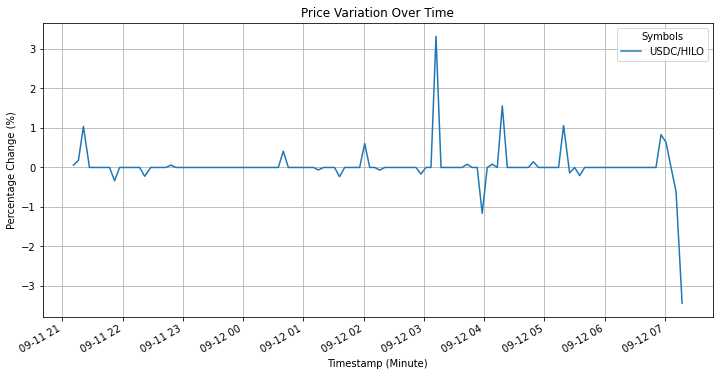

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df with columns 'timestamp', 'symbol1', 'symbol2', and 'price'
# Convert 'price' column to numeric (float) and handle non-numeric values
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Drop rows with NaN (missing) values in the 'price' column
df = df.dropna(subset=['price'])

# Convert 'timestamp' column to a datetime object
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Round the timestamp to the minute
df['timestamp'] = df['timestamp'].dt.floor('T')

# Combine 'symbol1' and 'symbol2' columns to create legend labels
df['symbol'] = df['symbol1'] + '/' + df['symbol2']

# Pivot the DataFrame to have timestamp as the index and 'symbol' as columns
pivot_data = df.pivot(index='timestamp', columns='symbol', values='price')

# Calculate the percentage change for each symbol's price within each minute
percentage_change_data = pivot_data.pct_change() * 100

# Plot the percentage change data
percentage_change_data.plot(figsize=(12, 6))
plt.xlabel('Timestamp (Minute)')
plt.ylabel('Percentage Change (%)')
plt.title('Price Variation Over Time')
plt.legend(title='Symbols')
plt.grid(True)
plt.show()

# Get price from all pair in DB

- Retrieve prices for all pairs in the database

In [6]:
import mysql.connector
import pandas as pd

cnx = mysql.connector.connect(user='root', 
    password='Password',
    host='127.0.0.1',
    database='CryptoDB',
    auth_plugin='mysql_native_password')

# create cursor
cursor = cnx.cursor()


# Function to get all pair_ids
def get_all_pair_ids():
    query = "SELECT id FROM pairs"
    cursor.execute(query)
    return [x[0] for x in cursor.fetchall()]

# Function to fetch all historical price data for a pair
def fetch_historical_price_data(pair_id):
    query = """SELECT p.timestamp, t0.symbol, t1.symbol, p.price
               FROM prices p
               INNER JOIN pairs pr ON p.pair_id = pr.id
               INNER JOIN tokens t0 ON pr.token0_id = t0.id
               INNER JOIN tokens t1 ON pr.token1_id = t1.id
               WHERE p.pair_id = %s
               ORDER BY p.timestamp ASC"""
    cursor.execute(query, (pair_id,))
    return cursor.fetchall()

# Get all pair_ids
pair_ids = get_all_pair_ids()

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each pair_id to fetch historical data and create a DataFrame
for pair_id in pair_ids:
    historical_data = fetch_historical_price_data(pair_id)
    if historical_data:  # Check if historical data exists for the pair
        df = pd.DataFrame(historical_data, columns=['timestamp', 'symbol1', 'symbol2', 'price'])
        dfs.append(df)

# Close the database connection
cursor.close()
cnx.close()

# Example usage: Access the first DataFrame in the list
if dfs:
    print(dfs[1])


              timestamp symbol1 symbol2     price
0   2023-09-11 21:06:42    WETH  BANANA  8.455E-7
1   2023-09-11 21:11:47    WETH  BANANA  8.462E-7
2   2023-09-11 21:16:53    WETH  BANANA  8.465E-7
3   2023-09-11 21:21:58    WETH  BANANA  8.465E-7
4   2023-09-11 21:27:03    WETH  BANANA  8.465E-7
..                  ...     ...     ...       ...
124 2023-09-12 07:37:29    WETH  BANANA  7.725E-7
125 2023-09-12 07:42:34    WETH  BANANA  7.725E-7
126 2023-09-12 07:47:40    WETH  BANANA  7.725E-7
127 2023-09-12 07:52:45    WETH  BANANA  7.725E-7
128 2023-09-12 07:57:50    WETH  BANANA  7.725E-7

[129 rows x 4 columns]


# Plot price variations

- Generate a graphical representation of price variations for all pairs

In [9]:
def plot_price_variations(dfs):
    """
    Plots the price variations from a list of DataFrames with zooming using Plotly.

    Args:
    dfs (list of DataFrame): List of DataFrames, each with columns 'timestamp', 'symbol1', 'symbol2', and 'price'.
    """
    # Concatenate all DataFrames into one DataFrame
    all_data = pd.concat(dfs, ignore_index=True)
    
    # Convert 'price' column to numeric (float) and handle non-numeric values
    all_data['price'] = pd.to_numeric(all_data['price'], errors='coerce')
    
    # Drop rows with NaN (missing) values in the 'price' column
    all_data = all_data.dropna(subset=['price'])
    
    # Convert 'timestamp' column to a datetime object
    all_data['timestamp'] = pd.to_datetime(all_data['timestamp'])
    
    # Round the timestamp to the minute
    all_data['timestamp'] = all_data['timestamp'].dt.floor('T')
    
    # Combine 'symbol1' and 'symbol2' columns to create legend labels
    all_data['symbol'] = all_data['symbol1'] + '/' + all_data['symbol2']
    
    # Pivot the DataFrame to have timestamp as the index and 'symbol' as columns
    pivot_data = all_data.pivot(index='timestamp', columns='symbol', values='price')
    
    # Calculate the percentage change for each symbol's price within each minute
    percentage_change_data = pivot_data.pct_change() * 100
    
    # Create an interactive Plotly figure
    fig = go.Figure()
    
    for column in percentage_change_data.columns:
        fig.add_trace(go.Scatter(x=percentage_change_data.index, y=percentage_change_data[column], name=column))
    
    # Update layout for better readability
    fig.update_layout(title='Price Variation Over Time', xaxis_title='Timestamp (Minute)', yaxis_title='Percentage Change (%)',
                      hovermode='x', showlegend=True)
    
    # Enable zooming
    fig.update_xaxes(rangeslider_visible=True)
    
    # Show the plot
    fig.show()

    
plot_price_variations(dfs)

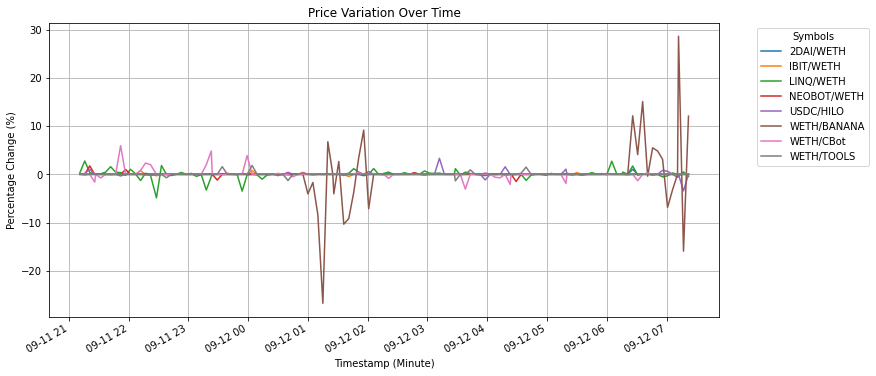

In [8]:
def plot_price_variations(dfs):
    """
    Plots the price variations from a list of DataFrames .

    Args:
    dfs (list of DataFrame): List of DataFrames, each with columns 'timestamp', 'symbol1', 'symbol2', and 'price'.
    """
    # Concatenate all DataFrames into one DataFrame
    all_data = pd.concat(dfs, ignore_index=True)
    
    # Convert 'price' column to numeric (float) and handle non-numeric values
    all_data['price'] = pd.to_numeric(all_data['price'], errors='coerce')
    
    # Drop rows with NaN (missing) values in the 'price' column
    all_data = all_data.dropna(subset=['price'])
    
    # Convert 'timestamp' column to a datetime object
    all_data['timestamp'] = pd.to_datetime(all_data['timestamp'])
    
    # Round the timestamp to the minute
    all_data['timestamp'] = all_data['timestamp'].dt.floor('T')
    
    # Combine 'symbol1' and 'symbol2' columns to create legend labels
    all_data['symbol'] = all_data['symbol1'] + '/' + all_data['symbol2']
    
    # Pivot the DataFrame to have timestamp as the index and 'symbol' as columns
    pivot_data = all_data.pivot(index='timestamp', columns='symbol', values='price')
    
    # Calculate the percentage change for each symbol's price within each minute
    percentage_change_data = pivot_data.pct_change() * 100
    
    # Plot the percentage change data
    ax = percentage_change_data.plot(figsize=(12, 6))
    plt.xlabel('Timestamp (Minute)')
    plt.ylabel('Percentage Change (%)')
    plt.title('Price Variation Over Time')
    
    # Place the legend to the right of the chart
    ax.legend(title='Symbols', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True)
    plt.show()

plot_price_variations(dfs)
